In [1]:
import pandas as pd
import numpy as np
import os
import sys 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [7]:
abs = os.getcwd()
abs = abs.replace("\\src\\Time_series\\food_consump","") 
#ab = ab + ("\\dataset\\")
abs

'c:\\Users\\abulf\\Documents\\Python_tutorial\\Assignments\\ML_framework'

In [8]:
sys.path.insert(0, abs   + "\\utils")

In [9]:
from common import process_labelencode
from common import corr_mat
from common import co_mat

In [10]:
traindf = pd.read_csv(abs + "/dataset/Time_series/food_consump/train.csv")
mealdf = pd.read_csv(abs + "/dataset/Time_series/food_consump/meal_info.csv")
fulfillmentdf = pd.read_csv(abs + "/dataset/Time_series/food_consump/fulfilment_center_info.csv")
traindf.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [7]:
df_all1 = traindf.groupby('week', as_index =False)['num_orders'].sum()
df_all1.head()

,week,num_orders
0,1,792261
1,2,787084
2,3,695262
3,4,743529
4,5,1198675


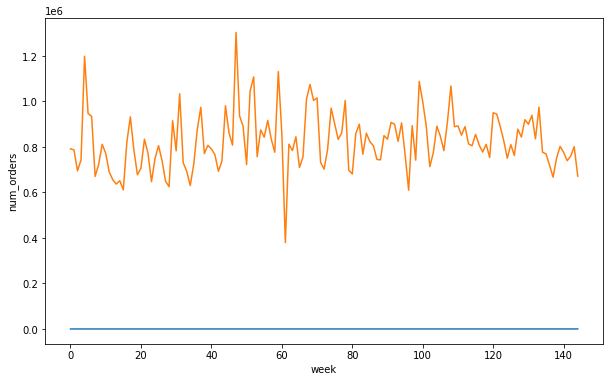

In [8]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('week')
plt.ylabel('num_orders')
plt.plot(df_all1)

In [9]:
traindf.drop(columns = ['id'], inplace = True)

In [10]:
comb_df = pd.merge(pd.merge(traindf, mealdf, how = 'inner', on = 'meal_id'), fulfillmentdf, how = 'inner', on = 'center_id')
comb_df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [11]:
df = comb_df.loc[(comb_df['meal_id'] == 1248), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area', 'region_code', 'meal_id', 'center_id', 'cuisine']]

In [12]:
df.shape

(9939, 13)

In [13]:
df = df.loc[(df['center_id'] == 55), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area', 'region_code', 'meal_id', 'center_id', 'cuisine']]

In [14]:
df.to_csv('df.csv')

In [17]:
comb_df.shape

(456548, 14)

In [11]:
comb_df.drop(columns = ['meal_id'], inplace = True)
comb_df.drop(columns = ['center_id'], inplace = True)

In [12]:
df = comb_df[['week', 'category', 'cuisine', 'city_code', 'region_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'center_type', 'op_area']]

In [13]:
comb_df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [14]:
df.cuisine = process_labelencode(df, "cuisine")
df.category = process_labelencode(df, "category")
df.center_type = process_labelencode(df, "center_type")
df.city_code = process_labelencode(df, "city_code")
df.region_code = process_labelencode(df, "region_code")

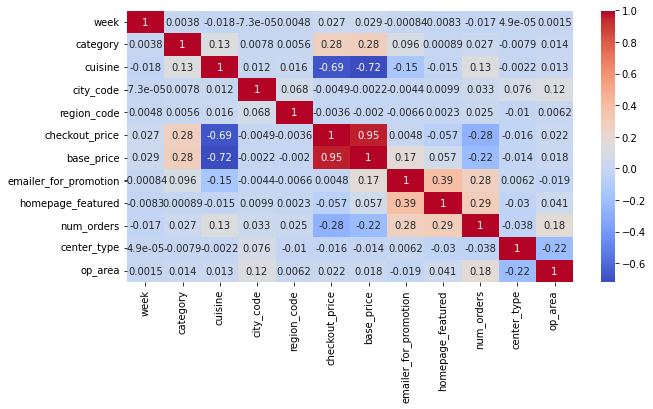

In [15]:
corr_mat(df)

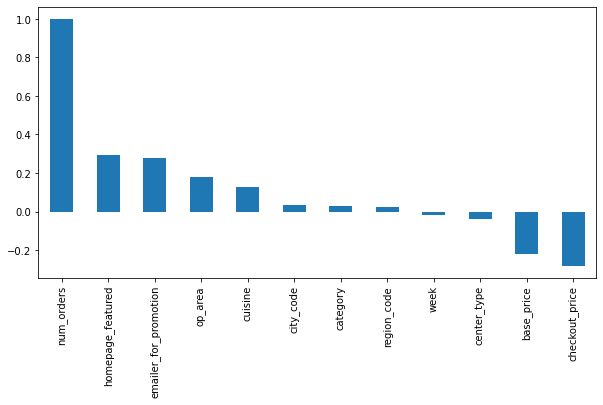

In [16]:
co_mat(df, 'num_orders')

In [17]:
df.corr()['num_orders'].abs().sort_values(ascending=False)

num_orders               1.000000
homepage_featured        0.294490
checkout_price           0.282108
emailer_for_promotion    0.277147
base_price               0.222306
op_area                  0.176976
cuisine                  0.127653
center_type              0.038199
city_code                0.033383
category                 0.026520
region_code              0.025300
week                     0.017210
Name: num_orders, dtype: float64

In [18]:
comb_df.isnull().sum()

week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [19]:
comb_df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [29]:
Thai_df = comb_df.loc[(comb_df['cuisine'] == 'Thai'), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]
Indian_df = comb_df.loc[(comb_df['cuisine'] == 'Indian'), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]
Italian_df = comb_df.loc[(comb_df['cuisine'] == 'Italian'), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]
Continental_df = comb_df.loc[(comb_df['cuisine'] == 'Continental'), ['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]

In [30]:
Thai_df.to_csv('Thai_df.csv')
Indian_df.to_csv('Indian_df.csv')
Italian_df.to_csv('Italian_df.csv')
Continental_df.to_csv('Continental_df.csv')